In [1]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


In [2]:
import torch
import numpy as np


# env_name = "button-press-topdown-v2"
env_name = "box-close-v2"
# env_name = "dial-turn-v2"
# env_name = "sweep-v2"
exp_name = "AESPA-22-02"
pair_algo = "ternary-500"
# reward_model_algo = "MR-exp"
reward_model_algo = "MR-linear"
test_pair_algo = "ternary-500-aug-bucket-4-knn"

os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAJECTORY_LENGTH = 25

In [3]:
import glob
from data_loading.load_data import load_dataset
from reward_learning.get_model import get_reward_model
from utils.path import get_reward_model_path


def predict_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    dataset = load_dataset(env_name)
    obs_dim = dataset["observations"].shape[1]
    act_dim = dataset["actions"].shape[1]

    print("obs_dim:", obs_dim, "act_dim:", act_dim)
    model_path_pattern = get_reward_model_path(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
        reward_model_tag="*",
    )
    model_files = glob.glob(model_path_pattern)
    model_list = []

    for model_file in model_files:
        model, _ = get_reward_model(
            reward_model_algo=reward_model_algo,
            obs_dim=obs_dim,
            act_dim=act_dim,
            model_path=model_file,
            allow_existing=True,
        )
        model_list.append(model)

    dataset = load_dataset(env_name)

    num_samples = len(dataset["observations"])
    batch_size = num_samples // 20
    model_outputs = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)

        obs_batch = torch.tensor(
            dataset["observations"][start_idx:end_idx], dtype=torch.float32
        ).to(device)
        act_batch = torch.tensor(
            dataset["actions"][start_idx:end_idx], dtype=torch.float32
        ).to(device)

        batch_model_outputs = []
        for model in model_list:
            rewards = model.batched_forward_trajectory(
                obs_batch=obs_batch, act_batch=act_batch
            )
            batch_model_outputs.append(rewards.detach().cpu().numpy())

        batch_predicted_rewards = np.mean(batch_model_outputs, axis=0)
        model_outputs.append(batch_predicted_rewards)

    predicted_rewards = np.concatenate(model_outputs, axis=0).squeeze()

    return predicted_rewards

In [4]:
from data_loading.load_data import load_dataset


dataset = load_dataset(
    env_name=env_name,
)
cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)
average_reward = np.mean(dataset["rewards"])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_reward_from_cumsum(start, end):
    """
    Get the reward from the cumulative sum between start and end indices.
    """

    if start == 0:
        return cumsum[end - 1]
    else:
        return cumsum[end - 1] - cumsum[start - 1]



def get_total_reward(s, e, reward_cumsum):
    return reward_cumsum[e - 1] - (reward_cumsum[s - 1] if s > 0 else 0)

def get_bucket_index(reward, bucket_ranges):
    for i, (low, high) in enumerate(bucket_ranges):
        if low <= reward <= high:  # high 포함 or 미포함은 상황 따라 조정
            return i
    return None  # 혹시라도 범위를 벗어나는 경우


In [5]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
from random import sample

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from data_generation.utils import save_feedbacks_npz
from data_loading.load_data import load_pair
from reward_learning.train_model import train_reward_model

def get_bucket_z_feedbacks(
    env_name,
    exp_name,
    result,
    k=20,
    z=10,
    select_ratio=0.005,
):
    # ----------- 1. trajectory reward 및 std 계산 -----------
    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2

    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    # feedbacks: trajectory pair list
    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo="ternary-10000",
    )

    # trajectory 인덱스만 모음
    trajectories = []
    for p in feedbacks:
        trajectories.append(p[0])
        trajectories.append(p[1])

    # 각 trajectory의 누적 reward 및 std 계산
    trajs = []
    for (s, e) in trajectories:
        r = mean_cum[e - 1] - (mean_cum[s - 1] if s > 0 else 0)
        v = var_cum[e - 1] - (var_cum[s - 1] if s > 0 else 0)
        std_ = np.sqrt(v)
        trajs.append(((s, e), r, std_))

    # ----------- 2. reward 기준 버킷 나누기 -----------
    trajs.sort(key=lambda x: x[1])  # reward 기준 정렬
    n = len(trajs)
    buckets = [trajs[n * i // k : n * (i + 1) // k] for i in range(k)]

    # ----------- 3. 신뢰구간 미겹침 조건 만족하는 pair 추출 -----------
    feedbacks_bucket = []
    total_traj_count = len(trajectories)
    num_per_bucket_pair = int((total_traj_count * select_ratio // k) ** 2)

    for i in range(k):
        for j in range(i + 1, k):
            trajs_i = buckets[i]
            trajs_j = buckets[j]

            local_pairs = []

            for traj_i in trajs_i:
                (s0, r0, std0) = traj_i
                upper_i = r0 + z * std0

                for traj_j in trajs_j:
                    (s1, r1, std1) = traj_j
                    lower_j = r1 - z * std1

                    if upper_i < lower_j:
                        local_pairs.append((s0, s1, 1.0))  # 충분히 구분 가능한 pair

            # 신뢰 가능한 pair 중 일부만 무작위 선택
            if len(local_pairs) > num_per_bucket_pair:
                feedbacks_bucket.extend(sample(local_pairs, num_per_bucket_pair))
            elif len(local_pairs) > 0:
                feedbacks_bucket.extend(local_pairs)

    print(f"[feedbacks_bucket] Generated {len(feedbacks_bucket)} confident pairs")

    return feedbacks_bucket

def get_bucket_conf_feedbacks(
    env_name,
    exp_name,
    result,
    k=20,
    num_per_bucket_pair=100,
):
    # ----------- 1. trajectory reward 및 std 계산 -----------
    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2

    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    # feedbacks: trajectory pair list
    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo="ternary-10000",
    )

    # trajectory 인덱스만 모음
    trajectories = []
    for p in feedbacks:
        trajectories.append(p[0])
        trajectories.append(p[1])

    # 각 trajectory의 누적 reward 및 std 계산
    trajs = []
    for (s, e) in trajectories:
        r = mean_cum[e - 1] - (mean_cum[s - 1] if s > 0 else 0)
        v = var_cum[e - 1] - (var_cum[s - 1] if s > 0 else 0)
        std_ = np.sqrt(v)
        trajs.append(((s, e), r, std_))

    # ----------- 2. reward 기준 버킷 나누기 -----------
    trajs.sort(key=lambda x: x[1])  # reward 기준 정렬
    n = len(trajs)
    buckets = [trajs[n * i // k : n * (i + 1) // k] for i in range(k)]

    # ----------- 3. 신뢰구간 미겹침 조건 만족하는 pair 추출 -----------
    feedbacks_bucket = []

    for i in range(k):
        for j in range(i + 1, k):
            trajs_i = buckets[i]
            trajs_j = buckets[j]

            local_pairs = []

            for traj_i in trajs_i:
                (s0, r0, std0) = traj_i

                for traj_j in trajs_j:
                    (s1, r1, std1) = traj_j

                    if sigmoid(r1 - r0) > 0.99:
                        local_pairs.append((s0, s1, 1.0))
                    elif sigmoid(r0 - r1) > 0.99:
                        local_pairs.append((s1, s0, 0.0))

            # 신뢰 가능한 pair 중 일부만 무작위 선택
            if len(local_pairs) > num_per_bucket_pair:
                feedbacks_bucket.extend(sample(local_pairs, num_per_bucket_pair))
            elif len(local_pairs) > 0:
                feedbacks_bucket.extend(local_pairs)

    print(f"[feedbacks_bucket] Generated {len(feedbacks_bucket)} confident pairs")

    return feedbacks_bucket


def augment_with_bucket_knn(env_name, exp_name, result, n=10000, min_k=10, max_k=20, num_per_bucket_pair=100, z=10):
    """
    reward 기반 클러스터링을 통해 trajectory를 bucket으로 나누고,
    각 bucket 쌍에서 신뢰구간 겹치지 않는 pair를 top_k 개 만큼 생성
    """

    # ----------- 1. Trajectory reward 정보 정리 -----------
    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2
    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    if n == 10000:
        feedbacks = load_pair(env_name, exp_name, "train", "ternary-10000")
    elif n == 1000:
        feedbacks = load_pair(env_name, exp_name, "train", "ternary-1000")
    elif n == 50000:
        feedbacks = load_pair(env_name, exp_name, "train", "ternary-100000")[:50000]

    trajectories = []
    for p in feedbacks:
        trajectories.append(p[0])
        trajectories.append(p[1])

    trajs = []
    for (s, e) in trajectories:
        r = mean_cum[e - 1] - (mean_cum[s - 1] if s > 0 else 0)
        v = var_cum[e - 1] - (var_cum[s - 1] if s > 0 else 0)
        std_ = np.sqrt(v)
        trajs.append(((s, e), r, std_))

    # ----------- 2. KMeans 클러스터링으로 Bucket 나누기 -----------
    rewards = np.array([r for _, r, _ in trajs]).reshape(-1, 1)
    best_k = min_k
    best_score = -1
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(rewards)
        score = silhouette_score(rewards, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_k = k

    print(f"[KMeans] Best k = {best_k} with silhouette score = {best_score:.4f}")
    final_kmeans = KMeans(n_clusters=best_k, random_state=0).fit(rewards)
    labels = final_kmeans.labels_

    # bucket 분리
    buckets = [[] for _ in range(best_k)]
    for traj, label in zip(trajs, labels):
        buckets[label].append(traj)

    # ----------- 각 bucket을 평균 reward 기준으로 정렬 -----------
    bucket_mean_rewards = []
    for i in range(best_k):
        rewards_in_bucket = [r for (_, r, _) in buckets[i]]
        mean_r = np.mean(rewards_in_bucket) if rewards_in_bucket else float('inf')
        bucket_mean_rewards.append((i, mean_r))

    # reward 평균 기준으로 index 재정렬
    sorted_bucket_indices = [i for i, _ in sorted(bucket_mean_rewards, key=lambda x: x[1])]
    sorted_buckets = [buckets[i] for i in sorted_bucket_indices]
    buckets = sorted_buckets  # overwrite

    # ----------- bucket_ranges 재구성 -----------
    bucket_ranges = []
    for i, bucket  in enumerate(buckets):
        bucket_rewards = np.array([r for (_, r, _) in bucket])
        bucket_ranges.append((bucket_rewards.min(), bucket_rewards.max()))
        print(f"Bucket {i}: Range = {bucket_rewards.min():.2f} to {bucket_rewards.max():.2f}, len: {len(bucket_rewards)}")

    def get_total_reward(s, e, cumsum):
        return cumsum[e - 1] - (cumsum[s - 1] if s > 0 else 0)

    def get_bucket_index(r, bucket_ranges):
        for i, (low, high) in enumerate(bucket_ranges):
            if low <= r <= high:
                return i
        return None

    # ----------- 3. Bucket 간 Confident Pair 생성 -----------
    feedbacks_bucket = []
    for i in range(best_k):
        for j in range(i + 1, best_k):
            trajs_i = buckets[i]
            trajs_j = buckets[j]
            local_pairs = []
            for traj_i in trajs_i:
                (s0, r0, std0) = traj_i
                upper_i = r0 + z * std0
                for traj_j in trajs_j:
                    (s1, r1, std1) = traj_j
                    lower_j = r1 - z * std1
                    if upper_i < lower_j:
                        local_pairs.append((s0, s1, 1.0))
            if len(local_pairs) > num_per_bucket_pair:
                feedbacks_bucket.extend(sample(local_pairs, num_per_bucket_pair))
            elif len(local_pairs) > 0:
                feedbacks_bucket.extend(local_pairs)

    print(f"[feedbacks_bucket] Generated {len(feedbacks_bucket)} confident pairs")



    # ----------- 4. 시각화 -----------

    # (1) Bucket-wise reward KDE plot
    plt.figure(figsize=(10, 6))
    for b in range(best_k):
        rewards = [r for (_, r, _) in buckets[b]]
        if not rewards:
            continue
        mean_val = np.mean(rewards)
        sns.kdeplot(rewards, label=f"B{b}", linewidth=1)
        max_density = sns.kdeplot(rewards).get_lines()[-1].get_data()[1].max()
        plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                 ha='center', va='bottom', fontsize=8)
    plt.xlabel("Reward")
    plt.ylabel("Density")
    plt.title("Reward Distribution by Bucket")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (2) Bucket-wise histogram
    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)
    for b in range(best_k):
        ax = axes[b // 5][b % 5]
        rewards = [r for (_, r, _) in buckets[b]]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")
    plt.suptitle("Histogram of Rewards per Bucket")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # (3) Pair count heatmap
    count_matrix = np.zeros((best_k, best_k), dtype=int)
    accuracy_matrix = np.full((best_k, best_k), np.nan)
    bucket_dict = defaultdict(list)

    for (s0, s1, _) in feedbacks_bucket:
        # 예측 reward → bucket index
        r0 = get_total_reward(s0[0], s0[1], mean_cum)
        r1 = get_total_reward(s1[0], s1[1], mean_cum)
        b0 = get_bucket_index(r0, bucket_ranges)
        b1 = get_bucket_index(r1, bucket_ranges)

        # 실제 reward
        real_r0 = get_reward_from_cumsum(s0[0], s0[1])
        real_r1 = get_reward_from_cumsum(s1[0], s1[1])

        # 예측 및 실제 preference
        pred_mu = np.where(b1 > b0, 1.0, np.where(b1 < b0, 0.0, 0.5))
        real_mu = np.where(real_r1 > real_r0, 1.0, np.where(real_r1 < real_r0, 0.0, 0.5))

        if b0 is None or b1 is None or b0 == b1:
            continue

        # 대각선 위로 정렬 (i < j)
        if b0 > b1:
            b0, b1 = b1, b0

        count_matrix[b0, b1] += 1
        bucket_dict[(b0, b1)].append(int(pred_mu == real_mu))

    # ----------- (2) Accuracy matrix 계산 -----------
    for (i, j), results in bucket_dict.items():
        acc = sum(results) / len(results)
        accuracy_matrix[i, j] = acc

    # ----------- (3) Overall Accuracy 계산 -----------
    all_corrects = [v for sublist in bucket_dict.values() for v in sublist]
    overall_accuracy = np.mean(all_corrects) if all_corrects else 0.0
    print(f"✅ Overall Pairwise Accuracy: {overall_accuracy:.4f}")

    # ----------- (4) 시각화 -----------

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Heatmap 1: Count
    sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                xticklabels=[f"B{j}" for j in range(best_k)],
                yticklabels=[f"B{i}" for i in range(best_k)])
    axes[0].set_title("Confident Pair Distribution")
    axes[0].set_xlabel("Bucket j (r1)")
    axes[0].set_ylabel("Bucket i (r0)")

    # Heatmap 2: Accuracy
    sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1],
                xticklabels=[f"B{j}" for j in range(best_k)],
                yticklabels=[f"B{i}" for i in range(best_k)],
                cbar_kws={'label': 'Accuracy'})
    axes[1].set_title("Prediction Accuracy per Bucket Pair")
    axes[1].set_xlabel("Bucket j (r1)")
    axes[1].set_ylabel("Bucket i (r0)")

    plt.tight_layout()
    plt.show()

    # ----------- 5. Augmented feedbacks 생성 -----------
    label_feedbacks = load_pair(env_name, exp_name, "train", "ternary-500").tolist()
    feedbacks_bucket = label_feedbacks + feedbacks_bucket

    pair_name = f"ternary-500-aug-bucket-knn"
    save_feedbacks_npz(env_name, exp_name, "train", pair_name, feedbacks_bucket)

    # ----------- 6. MR 모델 학습 -----------
    for i in range(3):
        train_reward_model(
            env_name=env_name,
            exp_name=exp_name,
            pair_algo=pair_name,
            reward_model_algo="MR-linear",
            reward_model_tag=f"{i:02d}",
            num_epoch=200,
        )

    # ----------- 7. 학습 모델 시각화 -----------
    predicted_rewards = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_name,
        reward_model_algo="MR-linear",
    )
    bucket_reward_cumsum = mean_cum              
    distribution_reward_cumsum = np.cumsum(predicted_rewards, dtype=np.float64)
    # distribution_reward_cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)

    train_trajectories = set()
    for (s0, e0), (s1, e1), _ in feedbacks:
        train_trajectories.add((s0, e0))
        train_trajectories.add((s1, e1))
    train_trajectories = list(train_trajectories)
    print(f"Total {len(train_trajectories)} train trajectories")
    print(f"Number of feedbacks: {len(feedbacks)}")

    bucketwise_rewards_train = [[] for _ in range(k)]
    for s, e in train_trajectories:
        r_bucket = get_total_reward(s, e, bucket_reward_cumsum)
        r_dist = get_total_reward(s, e, distribution_reward_cumsum)

        b = get_bucket_index(r_bucket, bucket_ranges)
        if b is not None:
            bucketwise_rewards_train[b].append(r_dist)

    plt.figure(figsize=(10, 6))
    for b in range(k):
        rewards = bucketwise_rewards_train[b]
        if rewards:
            # KDE 곡선
            sns.kdeplot(rewards, label=f"Bucket {b}", linewidth=1)

            # 평균값
            mean_val = np.mean(rewards)
            max_density = sns.kdeplot(rewards).get_lines()[-1].get_data()[1].max()

            # 텍스트 위치: (x=mean, y=곡선 최고점 근처 또는 적당한 위치)
            plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel("Predicted Trajectory Reward")
    plt.ylabel("Density")
    plt.title("Predicted Reward Distribution by Bucket (feedbacks)")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)

    for b in range(k):
        ax = axes[b // 5][b % 5]
        rewards = bucketwise_rewards_train[b]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")

    plt.suptitle("Bucket-wise Predicted Reward Histogram (feedbacks)")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()




In [6]:
from collections import defaultdict

from data_loading.load_data import load_pair
import matplotlib.pyplot as plt
import seaborn as sns


def augment_with_bucket(env_name, exp_name, result, k=20):
    # ----------- 1. 기본 정보 세팅 (trajectory 정리) -----------
    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2
    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo="ternary-10000",
    )
    trajectories = []

    for p in feedbacks:
        trajectories.append(p[0])
        trajectories.append(p[1])

    trajs = []
    for (s, e) in trajectories:
        r = mean_cum[e - 1] - (mean_cum[s - 1] if s > 0 else 0)
        v = var_cum[e - 1] - (var_cum[s - 1] if s > 0 else 0)
        std_ = np.sqrt(v)
        trajs.append(((s, e), r, std_))

    # ----------- 2. 버킷 나누기 -----------
    trajs.sort(key=lambda x: x[1])  # reward 기준 정렬
    n = len(trajs)
    buckets = [trajs[n * i // k : n * (i + 1) // k] for i in range(k)]
    bucket_ranges = [(buckets[i][0][1], buckets[i][-1][1]) for i in range(k)]

    for i, bucket_range in enumerate(bucket_ranges):
        print(f"Bucket {i}: Range = {bucket_range[0]:.2f} to {bucket_range[1]:.2f}")

    test_feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=test_pair_algo,
    )

    test_feedbacks = test_feedbacks[500:] # labeled data 제외
    # test_feedbacks = get_bucket_conf_feedbacks(
    #     env_name=env_name,
    #     exp_name=exp_name,
    #     result=result,
    #     k=k,
    #     num_per_bucket_pair=100,
    # )

    success_data = []

    for p in test_feedbacks:
        (s0, e0), (s1, e1), _ = p

        # 예측 reward 합
        r0 = get_total_reward(s0, e0, mean_cum)
        r1 = get_total_reward(s1, e1, mean_cum)

        # 버킷 인덱스 찾기
        b0 = get_bucket_index(r0, bucket_ranges)
        b1 = get_bucket_index(r1, bucket_ranges)
        pred_mu = np.where(b1 > b0, 1.0, np.where(b1 < b0, 0.0, 0.5))

        real_r0 = get_reward_from_cumsum(s0, e0)
        real_r1 = get_reward_from_cumsum(s1, e1)
        real_mu = np.where(real_r1 > real_r0, 1.0, np.where(real_r1 < real_r0, 0.0, 0.5))

        if b0 is not None and b1 is not None:
            success_data.append((b0, b1, pred_mu, real_mu))

    # (i, j) 위치마다 정답 여부를 저장할 딕셔너리
    bucket_dict = defaultdict(list)

    # success_data는 (b0, b1, pred_mu, real_mu)
    for b0, b1, pred_mu, real_mu in success_data:
        correct = int(pred_mu == real_mu)

        if b0 == b1:
            continue # 같은 버킷에 속하는 경우는 제외

        if b0 > b1:
            b0, b1 = b1, b0

        bucket_dict[(b0, b1)].append(correct)

    # (i, j, accuracy) 리스트 생성
    success_rate_i_j = []
    for (i, j), results in bucket_dict.items():
        acc = sum(results) / len(results)
        success_rate_i_j.append((i, j, acc))

    # heatmap matrix 만들기
    heat = np.full((k, k), np.nan)
    for i, j, acc in success_rate_i_j:
        heat[i, j] = acc

    # 전체 정답률 평균 계산
    all_accs = [acc for _, _, acc in success_rate_i_j]
    overall_accuracy = sum(all_accs) / len(all_accs) if all_accs else 0.0
    print(f"Overall Pairwise Accuracy: {overall_accuracy:.4f}")

    # heatmap 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(heat, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
                xticklabels=range(k), yticklabels=range(k), annot_kws={"size": 4})
    plt.title("Pairwise Accuracy Heatmap")
    plt.xlabel("Bucket j")
    plt.ylabel("Bucket i")
    plt.tight_layout()
    plt.show()


    # 분포 그리기
    
    bucket_matrix = np.zeros((k, k), dtype=int)

    # bucket_pairs = [(i, j) for i, j, _ in feedbacks_bucket_1]

    for (s0, e0), (s1, e1), _ in test_feedbacks:
        r0 = get_total_reward(s0, e0, mean_cum)
        r1 = get_total_reward(s1, e1, mean_cum)

        b0 = get_bucket_index(r0, bucket_ranges)
        b1 = get_bucket_index(r1, bucket_ranges)

        if b0 is not None and b1 is not None:
            if b0 == b1:
                continue
            if b0 > b1:
                b0, b1 = b1, b0
            bucket_matrix[b0, b1] += 1

    plt.figure(figsize=(6, 5))
    sns.heatmap(bucket_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"B{j}" for j in range(k)],
                yticklabels=[f"B{i}" for i in range(k)])
    plt.xlabel("Bucket j (r1)")
    plt.ylabel("Bucket i (r0)")
    plt.title("Confident Pair Distribution across Buckets")
    plt.tight_layout()
    plt.show()


    # ---------- 예측 reward 불러오기 ----------
    predicted_rewards = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=test_pair_algo,
        reward_model_algo=reward_model_algo,
    )
    bucket_reward_cumsum = mean_cum              
    # distribution_reward_cumsum = np.cumsum(predicted_rewards, dtype=np.float64)
    distribution_reward_cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)

    # ---------- (1) test_feedbacks 분석 ----------
    test_trajectories = set()
    for (s0, e0), (s1, e1), _ in test_feedbacks:
        test_trajectories.add((s0, e0))
        test_trajectories.add((s1, e1))
    test_trajectories = list(test_trajectories)
    print(f"Number of test trajectories: {len(test_trajectories)}")

    bucketwise_rewards_test = [[] for _ in range(k)]
    for s, e in test_trajectories:
        r_bucket = get_total_reward(s, e, bucket_reward_cumsum)
        r_dist = get_total_reward(s, e, distribution_reward_cumsum)

        b = get_bucket_index(r_bucket, bucket_ranges)
        if b is not None:
            bucketwise_rewards_test[b].append(r_dist)

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for b in range(k):
        rewards = bucketwise_rewards_test[b]
        if not rewards:
            continue

        mean_val = np.mean(rewards)

        # KDE 그리기 전 라인 개수 저장
        n_lines_before = len(ax.lines)

        # KDE 곡선 시도
        sns.kdeplot(rewards, label=f"Bucket {b}", linewidth=1, ax=ax)

        # 라인 개수 비교
        n_lines_after = len(ax.lines)
        kde_drawn = n_lines_after > n_lines_before

        if kde_drawn:
            # 마지막 생성된 라인에서 밀도값 가져오기
            _, y_data = ax.lines[-1].get_data()
            max_density = y_data.max()
            plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')
        else:
            # KDE 곡선이 그려지지 않은 경우 수직선 + 텍스트 (위치 고정)
            plt.axvline(x=mean_val, color='gray', linestyle='--', linewidth=1)
            plt.text(mean_val, 0.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')


    plt.xlabel("Predicted Trajectory Reward")
    plt.ylabel("Density")
    plt.title("Predicted Reward Distribution by Bucket (test_feedbacks)")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)

    for b in range(k):
        ax = axes[b // 5][b % 5]
        rewards = bucketwise_rewards_test[b]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")

    plt.suptitle("Bucket-wise Predicted Reward Histogram (feedbacks)")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # ---------- (2) feedbacks 분석 ----------
    train_trajectories = set()
    for (s0, e0), (s1, e1), _ in feedbacks:
        train_trajectories.add((s0, e0))
        train_trajectories.add((s1, e1))
    train_trajectories = list(train_trajectories)
    print(f"Total {len(train_trajectories)} train trajectories")
    print(f"Number of feedbacks: {len(feedbacks)}")

    bucketwise_rewards_train = [[] for _ in range(k)]
    for s, e in train_trajectories:
        r_bucket = get_total_reward(s, e, bucket_reward_cumsum)
        r_dist = get_total_reward(s, e, distribution_reward_cumsum)

        b = get_bucket_index(r_bucket, bucket_ranges)
        if b is not None:
            bucketwise_rewards_train[b].append(r_dist)

    plt.figure(figsize=(10, 6))
    for b in range(k):
        print (f"Bucket {b}: {len(bucketwise_rewards_train[b])} feedbacks")
        rewards = bucketwise_rewards_train[b]
        if rewards:
            # KDE 곡선
            sns.kdeplot(rewards, label=f"Bucket {b}", linewidth=1)

            # 평균값
            mean_val = np.mean(rewards)
            max_density = sns.kdeplot(rewards).get_lines()[-1].get_data()[1].max()

            # 텍스트 위치: (x=mean, y=곡선 최고점 근처 또는 적당한 위치)
            plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel("Predicted Trajectory Reward")
    plt.ylabel("Density")
    plt.title("Predicted Reward Distribution by Bucket (feedbacks)")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)

    for b in range(k):
        ax = axes[b // 5][b % 5]
        rewards = bucketwise_rewards_train[b]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")

    plt.suptitle("Bucket-wise Predicted Reward Histogram (feedbacks)")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    traj_truth_rewards = []

    total = 0
    correct = 0

    for p in test_feedbacks:
        (s0, e0), (s1, e1), mu  = p


        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)
        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))


    print(f"Total: {total}, Correct: {correct}, Accuracy: {correct / total:.4f}")

    
    r0_list = [r0 for r0, _ in traj_truth_rewards]
    r1_list = [r1 for _, r1 in traj_truth_rewards]

    bins =  25
    range_ = [[0, 250], [0, 250]]
    heatmap, xedges, yedges = np.histogram2d(r0_list, r1_list, bins=bins, range=range_)

    # 비율 계산
    total = np.sum(heatmap)
    heatmap_ratio = heatmap / total  # 0~1 사이 값

    # 감마 조정으로 색 진하게
    gamma = 0.3
    adjusted_heatmap = np.power(heatmap_ratio, gamma)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        adjusted_heatmap.T, origin="lower", aspect="equal",
        extent=[0, 250, 0, 250], cmap="Blues", vmin=0, vmax=np.max(adjusted_heatmap)
    )
    plt.colorbar(im, label="Relative Density")
    plt.xlabel("Reward 0")
    plt.ylabel("Reward 1")
    plt.title(f"Augmented Trajectory Pairs Heatmap with Percentages ({test_pair_algo})")

    plt.tight_layout()
    plt.show()
    




In [7]:
def conf_heatmap(
    env_name,
    exp_name,
    result,
    mu_0 = 0.999,
):
    feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="test",
        pair_algo="binary-10000",
    )
    print(f"Number of feedbacks: {len(feedbacks)}")

    data = np.array(result)
    mean = data[:, 1]
    mean_cum = np.cumsum(mean, dtype=np.float64)

    
    traj_truth_rewards = []

    total = 0
    correct = 0

    for p in feedbacks:
        (s0, e0), (s1, e1), mu  = p

        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)

        predicted_r0 = get_total_reward(s0, e0, mean_cum)
        predicted_r1 = get_total_reward(s1, e1, mean_cum)

        if sigmoid(predicted_r1 - predicted_r0) < mu_0 and sigmoid(predicted_r0 - predicted_r1) < mu_0:
            continue

        if mu != 0.5:
            total += 1
        if mu == 1.0 and predicted_r0 < predicted_r1:
            correct += 1
        elif mu == 0.0 and predicted_r0 > predicted_r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))


    print(f"Total: {total}, Correct: {correct}, Accuracy: {correct / total:.4f}")

    
    r0_list = [r0 for r0, _ in traj_truth_rewards]
    r1_list = [r1 for _, r1 in traj_truth_rewards]

    bins =  25
    range_ = [[0, 250], [0, 250]]
    heatmap, xedges, yedges = np.histogram2d(r0_list, r1_list, bins=bins, range=range_)

    # 비율 계산
    total = np.sum(heatmap)
    heatmap_ratio = heatmap / total  # 0~1 사이 값

    # 감마 조정으로 색 진하게
    gamma = 0.3
    adjusted_heatmap = np.power(heatmap_ratio, gamma)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        adjusted_heatmap.T, origin="lower", aspect="equal",
        extent=[0, 250, 0, 250], cmap="Blues", vmin=0, vmax=np.max(adjusted_heatmap)
    )
    plt.colorbar(im, label="Relative Density")
    plt.xlabel("Reward 0")
    plt.ylabel("Reward 1")
    plt.title(f"Augmented Trajectory Pairs Heatmap with Percentages ({mu})")

    plt.tight_layout()
    plt.show()


In [8]:
from reward_learning.train_model import train_reward_model


def train_mr(env_name, exp_name):
    for i in range(7):
        train_reward_model(
            env_name=env_name,
            exp_name=exp_name,
            pair_algo="ternary-500",
            reward_model_algo="MR-exp",
            reward_model_tag=f"{i:02d}",
            num_epoch=200,
        )

In [9]:
def aug_pairs_distribution(test_pair_algo):
    aug_feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=test_pair_algo,
    )

    if "aug" in test_pair_algo:
        aug_feedbacks = aug_feedbacks[500:]

    traj_truth_rewards = []

    total = 0
    correct = 0

    for p in aug_feedbacks:
        (s0, e0), (s1, e1), mu  = p


        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)
        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))


    print(f"Total: {total}, Correct: {correct}, Accuracy: {correct / total:.4f}")

    
    r0_list = [r0 for r0, _ in traj_truth_rewards]
    r1_list = [r1 for _, r1 in traj_truth_rewards]

    bins =  25
    range_ = [[0, 250], [0, 250]]
    heatmap, xedges, yedges = np.histogram2d(r0_list, r1_list, bins=bins, range=range_)

    # 비율 계산
    total = np.sum(heatmap)
    heatmap_ratio = heatmap / total  # 0~1 사이 값

    # 감마 조정으로 색 진하게
    gamma = 0.3
    adjusted_heatmap = np.power(heatmap_ratio, gamma)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        adjusted_heatmap.T, origin="lower", aspect="equal",
        extent=[0, 250, 0, 250], cmap="Blues", vmin=0, vmax=np.max(adjusted_heatmap)
    )
    plt.colorbar(im, label="Relative Density")
    plt.xlabel("Reward 0")
    plt.ylabel("Reward 1")
    plt.title(f"Augmented Trajectory Pairs Heatmap with Percentages ({test_pair_algo})")

    plt.tight_layout()
    plt.show()

In [10]:
from data_generation.data_research import calculate_from_mr


def main():
    # train_mr(env_name, exp_name)
    result = calculate_from_mr(env_name, exp_name)
    # augment_with_bucket(
    #     env_name=env_name,
    #     exp_name=exp_name,
    #     result=result,
    #     k=20,
    # )

    augment_with_bucket_knn(
        env_name=env_name,
        exp_name=exp_name,
        result=result,
        n=10000,
        min_k=10,
        max_k=20,
        num_per_bucket_pair=100,
        z=3.1,
    )
    aug_pairs_distribution(test_pair_algo="ternary-500-aug-bucket-knn")
    # aug_pairs_distribution(test_pair_algo="ternary-500-aug-conf")
    # aug_pairs_distribution(test_pair_algo="ternary-500-aug-bucket-1")
    # aug_pairs_distribution(test_pair_algo="ternary-500-aug-bucket-2")
    # aug_pairs_distribution(test_pair_algo="ternary-500-aug-bucket-3")
    # aug_pairs_distribution(test_pair_algo="ternary-500-aug-bucket-4")
    # aug_pairs_distribution(test_pair_algo="ternary-500")

Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_00.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_01.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_02.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_03.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_04.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_05.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_06.pth
[KMeans] Best k = 11 with silhouette score = 0.5328
Bucket 0: Range = -13.33 to -8.66, len: 671
Bucket 1: Range = -8.66 to -6.97, len: 3389
Bucket 2: Range = -6.97 to -5.77, len: 6491
Bucket 3: Range = -5.77 to -4.29, len: 2835
Bucket 4: Range = -4.28 to -2.63, len: 2065
Bucket 5: Range = -2.63 to -0.97, len: 1759
Bucket 6: Range = -0.97 to 1.65, len: 1105
Bucket 7: Range = 1.68 to 4.88, len: 482
Bucket 8: Range = 4.90 to 

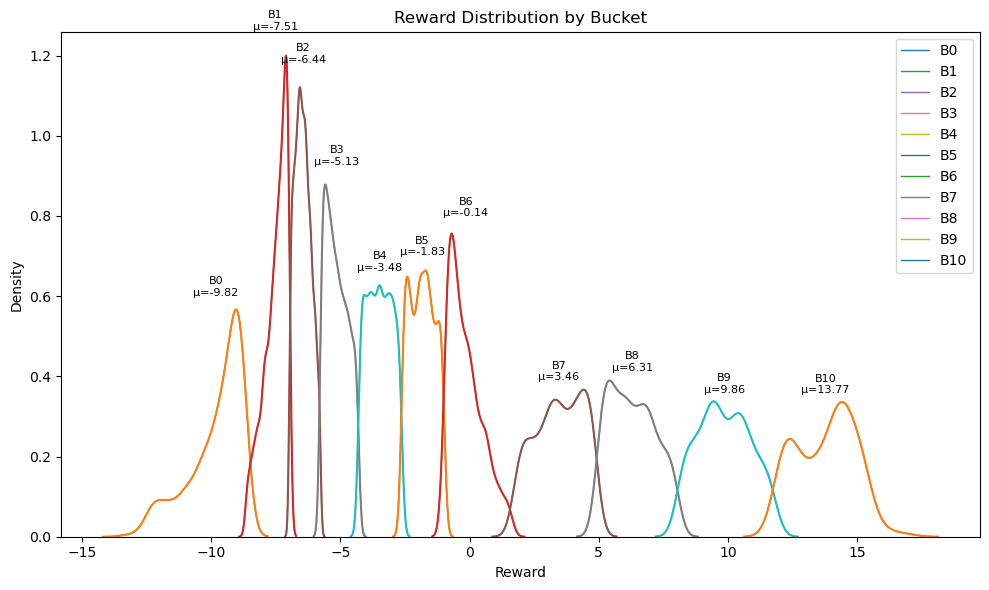

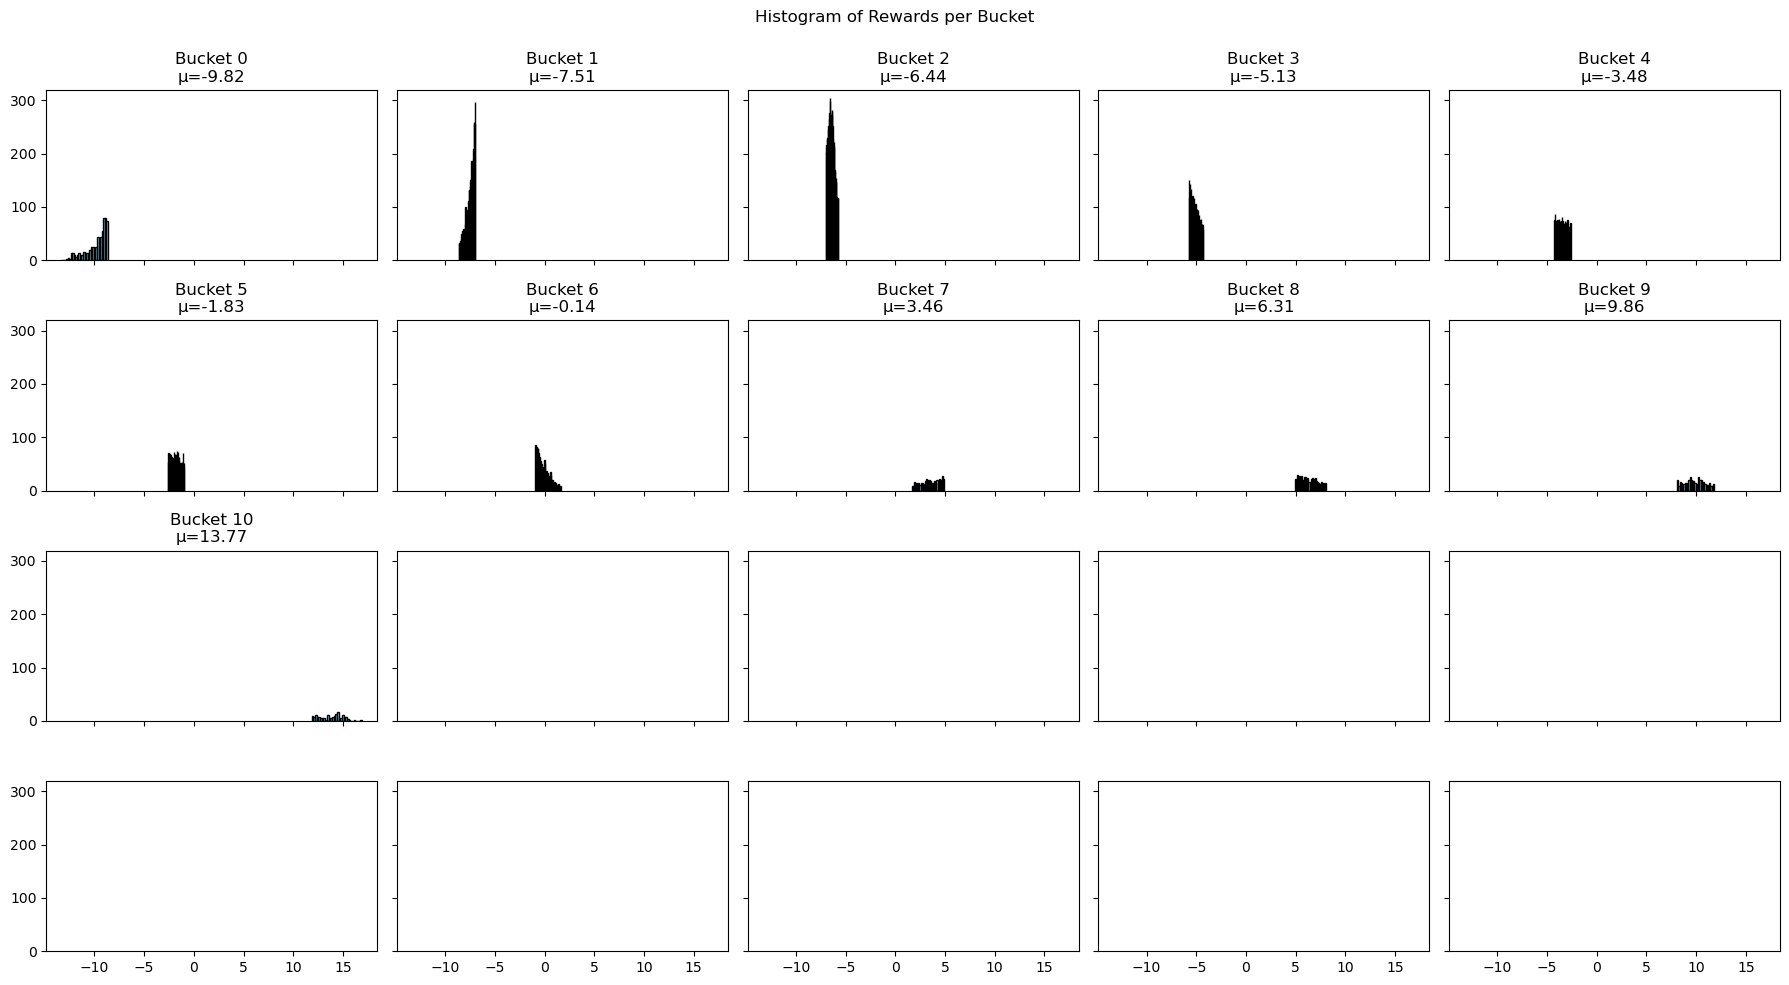

✅ Overall Pairwise Accuracy: 0.8902


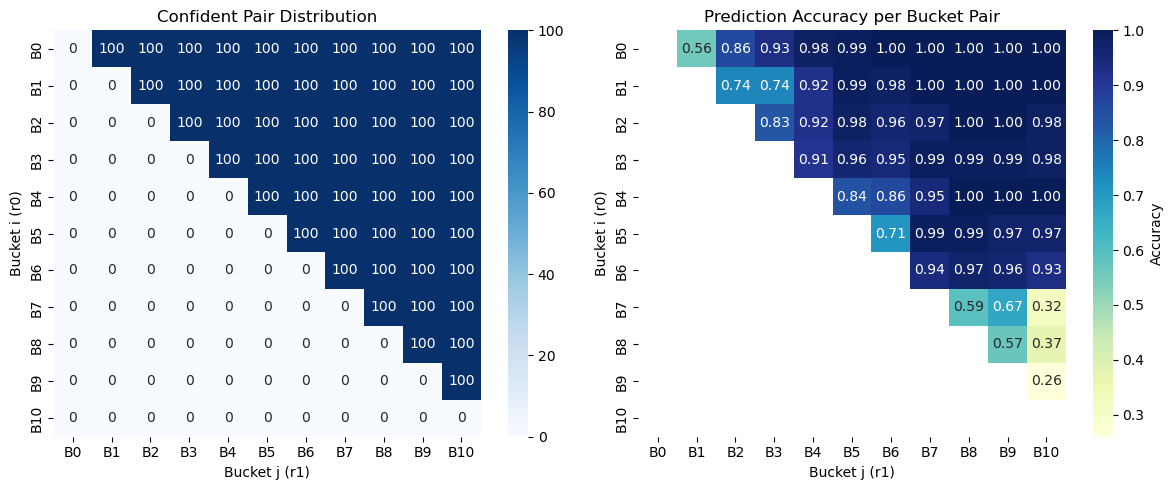

Saved feedbacks at pair/box-close-v2/AESPA-22-02/train/ternary-500-aug-bucket-knn.npz
Loaded pair/box-close-v2/AESPA-22-02/train/ternary-500-aug-bucket-knn.npz dataset
Processed data with 6000 samples
Loaded pair/box-close-v2/AESPA-22-02/val/ternary-500-aug-bucket-knn.npz dataset
obs_dim: 39 act_dim: 4
Skipping model initialization because already exists
Loaded pair/box-close-v2/AESPA-22-02/train/ternary-500-aug-bucket-knn.npz dataset
Processed data with 6000 samples
Loaded pair/box-close-v2/AESPA-22-02/val/ternary-500-aug-bucket-knn.npz dataset
obs_dim: 39 act_dim: 4
Skipping model initialization because already exists
Loaded pair/box-close-v2/AESPA-22-02/train/ternary-500-aug-bucket-knn.npz dataset
Processed data with 6000 samples
Loaded pair/box-close-v2/AESPA-22-02/val/ternary-500-aug-bucket-knn.npz dataset
obs_dim: 39 act_dim: 4
Skipping model initialization because already exists
obs_dim: 39 act_dim: 4
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500-aug-bucket

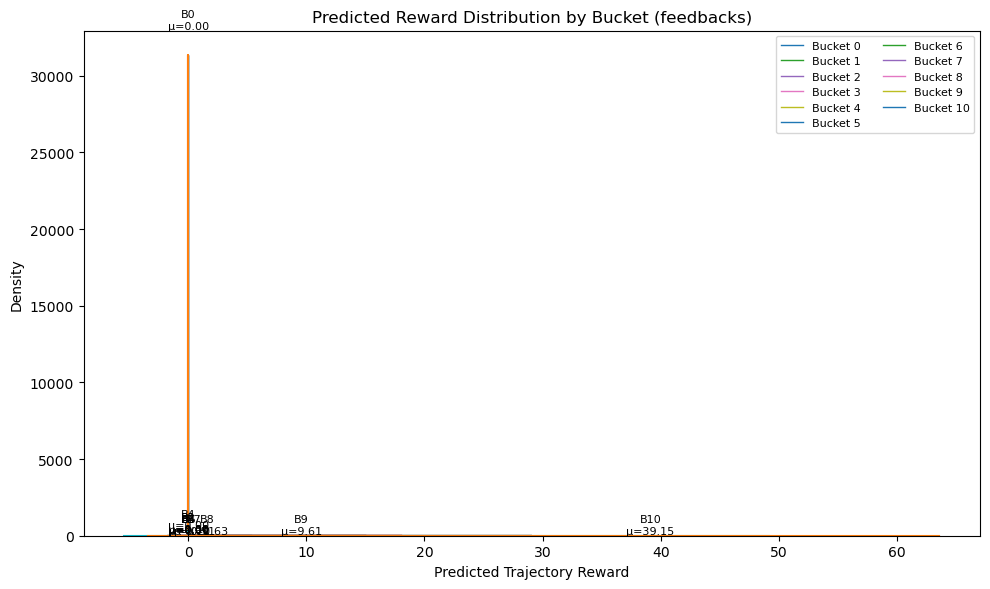

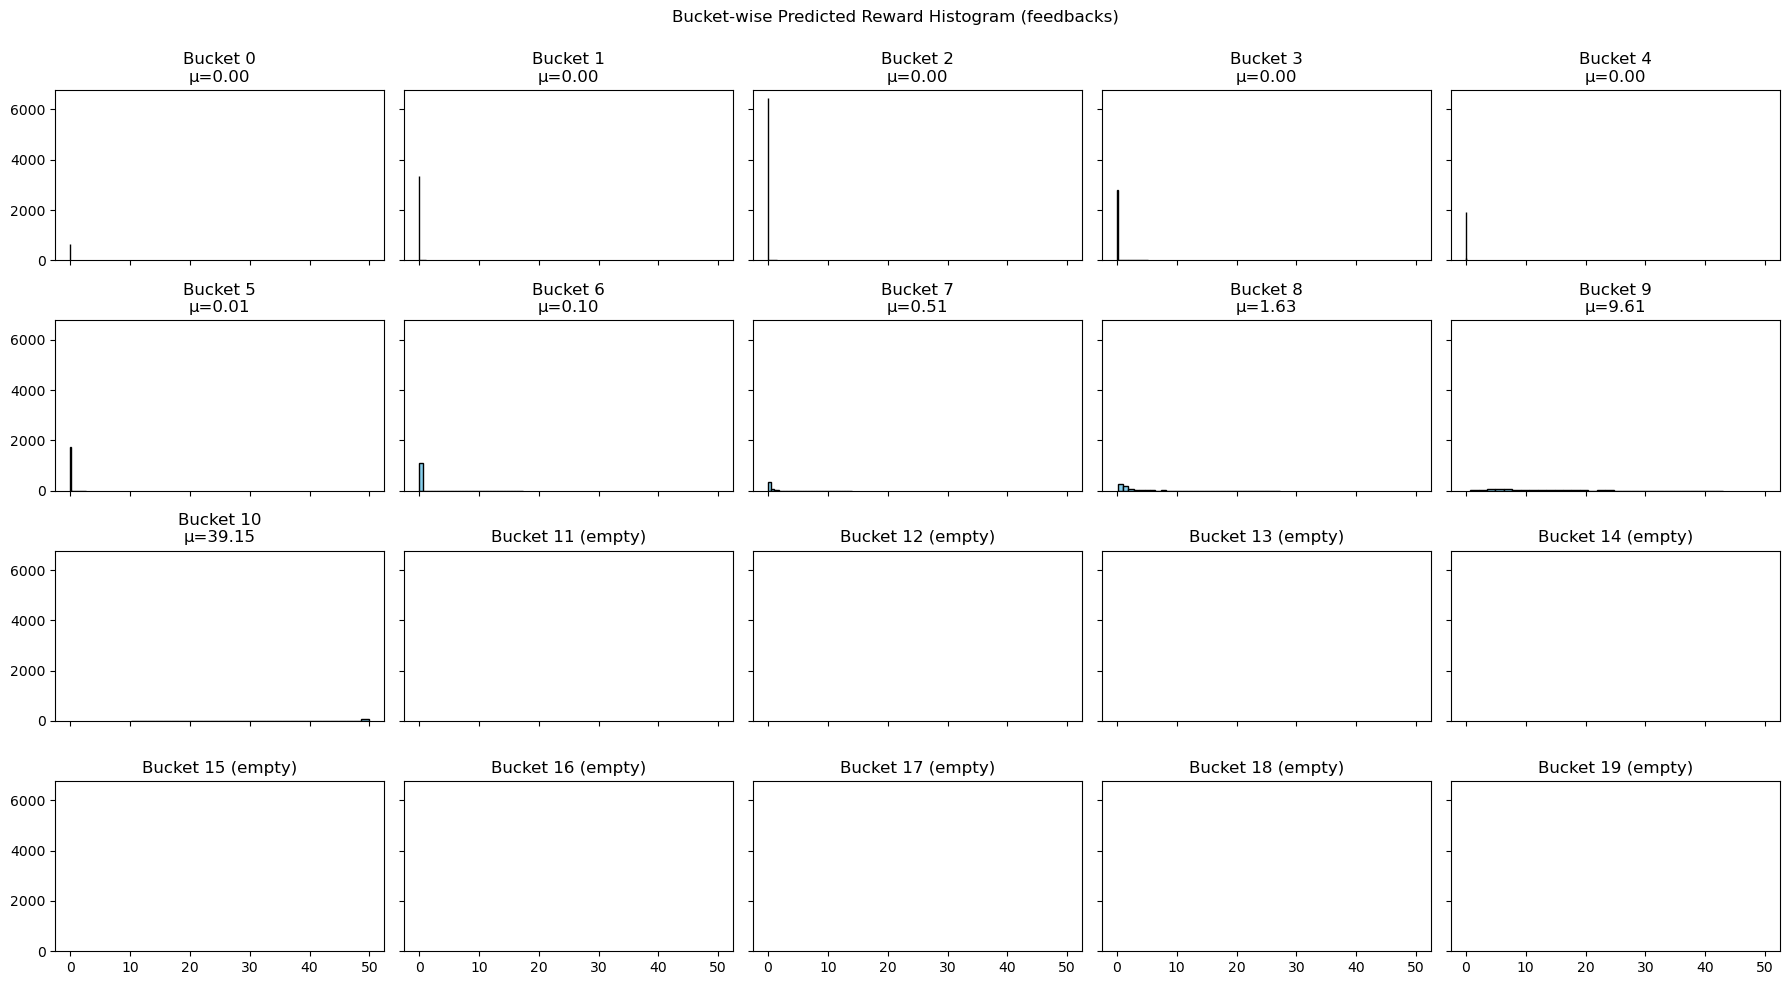

Total: 5500, Correct: 4896, Accuracy: 0.8902


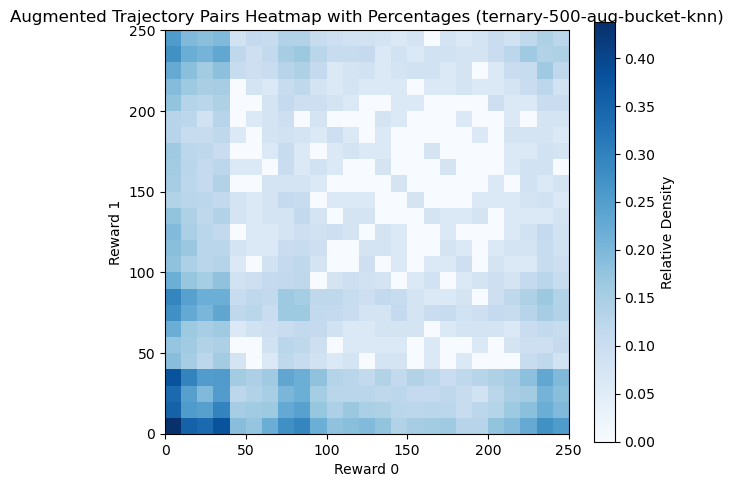

In [11]:
main()

In [ ]:
result = calculate_from_mr(env_name, exp_name)


Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_00.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_01.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_02.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_03.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_04.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_05.pth
Model loaded from model/box-close-v2/AESPA-22-02/reward/ternary-500/MR-exp_06.pth


In [ ]:
conf_heatmap(
    env_name=env_name,
    exp_name=exp_name,
    result=result,
    mu_0=0.9,
)